In [ ]:
!pip install optuna
import optuna
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree


#random forest uygulayacağım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")

In [ ]:
#Bu liste modelde kullanmak istediğim sütunları içeriyor.
columns_to_use = [
    #Tahmin etmek istediğim hedef sütunlar:
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput',

    #Sayısal özellikler:
    'dataRead', 'dataWritten', 'billableDuration', 'rowsCopied', 'rowsRead',
    'totalBillableDuration', 'queuingDuration', 'timeToFirstByte',
    'interimDataWritten', 'interimRowsCopied',
    'sinkPeakConnections', 'sourcePeakConnections',

    #Kategorik özellikler:
    'activityName', 'activityRunEnd', 'activityRunId', 'activityRunStart',
    'activityType', 'pipelineName', 'pipelineRunId', 'status',
    'billable_meterType', 'billable_unit', 'totalBillable_meterType',
    'totalBillable_unit', 'dataConsistencyVerification',
    'effectiveIntegrationRuntime', 'queueStatus',
    'integrationRuntime_name', 'integrationRuntime_type',
    'integrationRuntime_location', 'integrationRuntimeName'
]

#Veriyi sadece belirlenen sütunlarla filtreleyip ve eksik değerleri attım.
df = df[columns_to_use].dropna()

#Kategorik sütunlar
categorical_features = [
    'activityName', 'activityRunEnd', 'activityRunId', 'activityRunStart',
    'activityType', 'pipelineName', 'pipelineRunId', 'status',
    'billable_meterType', 'billable_unit', 'totalBillable_meterType',
    'totalBillable_unit', 'dataConsistencyVerification',
    'effectiveIntegrationRuntime', 'queueStatus',
    'integrationRuntime_name', 'integrationRuntime_type',
    'integrationRuntime_location', 'integrationRuntimeName'
]

#Sayısal sütunlar
numerical_features = [col for col in df.columns if col not in categorical_features + [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]]

#Bağımlı değişkenler (tahmin etmek istediklerim)
target_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# X ve y'yi ayırıyorum.
X = df.drop(columns=target_columns)
y = df[target_columns]

In [ ]:
#Kategorik ve sayısal özellikleri ayrı işliyorum
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Random Forest algoritmasını uyguluyorum.
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# Eğitim/test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Modeli eğit
pipeline.fit(X_train, y_train)

# Tahmin
y_pred = pipeline.predict(X_test)

In [ ]:
#Tahmin edilmiş değerlerin dataframe karşılaştırması (ilk satır için)
rows = []

i = 0  #İlk gözlem

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Karşılaştırmayı gösteriyorum.
prediction_df = pd.DataFrame(rows)
print("Random Forest Tahmin Sonuçları:")
print(prediction_df)


Random Forest Tahmin Sonuçları:
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs    1261651.00     1331623.51
1      copyDuration       1257.00        1283.77
2   durationInQueue       1230.00        1220.74
3     queueDuration       1229.00        1227.52
4  transferDuration         20.00          25.18
5     totalDuration       1257.00        1282.22
6        throughput        391.25         661.54


In [ ]:
#Performans metriklerini her hedef sütun için yazdırıyorum.
print("Her Süre Sütunu İçin Random Forest Performans Skorları:\n")

for i, col in enumerate(y.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]  # Random Forest tahminleri

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}")
    print(f"  MAE   : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE  : {round(rmse, 2)}")
    print(f"  R²    : {round(r2, 4)}\n")


Her Süre Sütunu İçin Random Forest Performans Skorları:

durationInMs:
  MSE   : 106993519683.98
  MAE   : 126401.0
  MAE (%) : 26.26%
  RMSE  : 327098.64
  R²    : 0.535

copyDuration:
  MSE   : 8089.88
  MAE   : 15.11
  MAE (%) : 2.76%
  RMSE  : 89.94
  R²    : 0.9661

durationInQueue:
  MSE   : 40.93
  MAE   : 1.69
  MAE (%) : 0.34%
  RMSE  : 6.4
  R²    : 0.9998

queueDuration:
  MSE   : 2.96
  MAE   : 0.9
  MAE (%) : 0.18%
  RMSE  : 1.72
  R²    : 1.0

transferDuration:
  MSE   : 1315.91
  MAE   : 8.12
  MAE (%) : 23.92%
  RMSE  : 36.28
  R²    : 0.8933

totalDuration:
  MSE   : 8084.93
  MAE   : 14.97
  MAE (%) : 2.73%
  RMSE  : 89.92
  R²    : 0.9662

throughput:
  MSE   : 24866.19
  MAE   : 33.6
  MAE (%) : 39.52%
  RMSE  : 157.69
  R²    : 0.794



In [ ]:
#Optimizasyon için en iyi parametreleri bulmak adına GridSearchCV kullandım.
param_grid = {
    'regressor__estimator__n_estimators': [50, 100],
    'regressor__estimator__max_depth': [5, 10],
    'regressor__estimator__min_samples_split': [2, 5],
    'regressor__estimator__min_samples_leaf': [1, 2]
}

#GridSearchCV (error_score='raise' ile tam hata alıyorum.)
grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='r2',
                           n_jobs=-1, error_score= 'raise')

#Eğitim başlatılıyor.
grid_search.fit(X_train, y_train)

#Sonuçlar
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi R2 skoru:", grid_search.best_score_)

En iyi parametreler: {'regressor__estimator__max_depth': 10, 'regressor__estimator__min_samples_leaf': 1, 'regressor__estimator__min_samples_split': 2, 'regressor__estimator__n_estimators': 50}
En iyi R2 skoru: 0.849810412551324


In [ ]:
#Optimizasyon için RandomizedSearchCV kullanarak en iyi parametrelere ulaşmaya çalıştım.
base_model = MultiOutputRegressor(RandomForestRegressor(random_state=42))

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', base_model)
])

#Parametre Aralıkları (tek estimator için yazdım.)
param_dist = {
    'regressor__estimator__n_estimators': [20, 40, 60],
    'regressor__estimator__min_samples_split': [4, 6, 8],
    'regressor__estimator__min_samples_leaf': [2, 4, 6],
    'regressor__estimator__max_depth': [4, 6, 8, 10],
}

#RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='r2',
    cv=2,
    verbose=0,
    random_state=42,
    error_score='raise'
)

#Eğitim
random_search.fit(X_train, y_train)

#Sonuçlar
print("En iyi parametreler:", random_search.best_params_)
print(f"En iyi R² skoru: {random_search.best_score_:.4f}")


En iyi parametreler: {'regressor__estimator__n_estimators': 60, 'regressor__estimator__min_samples_split': 4, 'regressor__estimator__min_samples_leaf': 2, 'regressor__estimator__max_depth': 10}
En iyi R² skoru: 0.8420


In [ ]:
#Bayes optimizasyonu uygulayarak en iyi parametreye ulaşmaya çalışıyorum.
optuna.logging.set_verbosity(optuna.logging.WARNING) #optuna loglarını sessize aldım.

#Optuna ile hiperparametre optimizasyonu
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 5)

#Model pipeline (ön işleme + çok çıkışlı regresyon)
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", MultiOutputRegressor(RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )))
    ])

    #cross_val_score ile değerlendirme
    scores = cross_val_score(model, X_train, y_train, cv=2, scoring='r2', error_score='raise')
    return np.mean(scores)

study = optuna.create_study(direction="maximize") #Optuna çalışmaya başlıyor.
study.optimize(objective, n_trials=30) #Belirli sayıda deneme yaptırdım. (Bayes optimizasyonu yapılıyor)

#Sonuçlar
print("En iyi parametreler:", study.best_params)
print("En iyi R2 skoru:", study.best_value)

En iyi parametreler: {'n_estimators': 75, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 3}
En iyi R2 skoru: 0.8453742523176182


In [ ]:
#Optimizasyonlar sonucu elde ettiğim en iyi parametreleri burada yerine koyarak  deniyorum ve en iyi sonuç vereni tutacağım. (en iyi sonucu bayes parametrelerinden elde ettim.)
best_params = {
    'max_depth': 9,
    'min_samples_leaf': 3,
    'min_samples_split': 4,
    'n_estimators': 75
}

#Modeli en iyi parametrelerle oluşturuyorum.
rf = RandomForestRegressor(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

multi_rf = MultiOutputRegressor(rf)

#Pipeline'ı oluşturuyorum.
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', multi_rf)
])

#Modeli eğitimi
pipeline.fit(X_train, y_train)

#Tahmin
y_pred = pipeline.predict(X_test)

#En iyi parametrelere göre yeni performans metrik sonuçları
print("Her Süre Sütunu İçin Performans Skorları:\n")

for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}")
    print(f"  MAE   : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE  : {round(rmse, 2)}")
    print(f"  R²    : {round(r2, 4)}\n")

Her Süre Sütunu İçin Performans Skorları:

durationInMs:
  MSE   : 100811341236.54
  MAE   : 141350.42
  MAE (%) : 29.36%
  RMSE  : 317508.02
  R²    : 0.5618

copyDuration:
  MSE   : 8192.59
  MAE   : 15.43
  MAE (%) : 2.82%
  RMSE  : 90.51
  R²    : 0.9657

durationInQueue:
  MSE   : 30.57
  MAE   : 1.77
  MAE (%) : 0.35%
  RMSE  : 5.53
  R²    : 0.9999

queueDuration:
  MSE   : 2.47
  MAE   : 0.9
  MAE (%) : 0.18%
  RMSE  : 1.57
  R²    : 1.0

transferDuration:
  MSE   : 1798.12
  MAE   : 9.38
  MAE (%) : 27.61%
  RMSE  : 42.4
  R²    : 0.8542

totalDuration:
  MSE   : 8134.11
  MAE   : 15.18
  MAE (%) : 2.77%
  RMSE  : 90.19
  R²    : 0.966

throughput:
  MSE   : 25459.79
  MAE   : 38.86
  MAE (%) : 45.71%
  RMSE  : 159.56
  R²    : 0.7891



In [ ]:
#Tahmin edilmiş değerlerin dataframe karşılaştırması (ilk satır için)
rows = []

i = 0  # İlk gözlem

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Karşılaştırmayı gösteriyorum.
prediction_df = pd.DataFrame(rows)
print("Random Forest Tahmin Sonuçları:")
print(prediction_df)


Random Forest Tahmin Sonuçları:
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs    1261651.00     1311757.12
1      copyDuration       1257.00        1294.96
2   durationInQueue       1230.00        1223.38
3     queueDuration       1229.00        1227.62
4  transferDuration         20.00          26.73
5     totalDuration       1257.00        1297.24
6        throughput        391.25         633.63


In [ ]:
#En iyi parametreleri Optuna'dan aldım.
best_params = study.best_params

#En iyi parametrelerle pipeline oluşturuyorum.
best_model = Pipeline([
    ("preprocessor", preprocessor),  # Daha önce tanımladığım ColumnTransformer
    ("regressor", MultiOutputRegressor(RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )))
])

#Model eğitimi
best_model.fit(X_train, y_train)

#Özellik isimlerini hazırlama
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_features = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([encoded_features, numerical_features])

#Çoklu çıktı regressor içindeki her hedef için ilk karar ağacının çizimi
multioutput_model = best_model.named_steps['regressor']

for i, col_name in enumerate(y_train.columns):
    rf = multioutput_model.estimators_[i]
    first_tree = rf.estimators_[0]

    plt.figure(figsize=(30, 10))
    plot_tree(first_tree, feature_names=feature_names, filled=True, rounded=True, max_depth=3, fontsize=10)
    plt.title(f"Karar Ağacı - Hedef: {col_name}")
    plt.show()

#Hedef sütunlarımın her biri için karar ağacı çizdirdim.

Output hidden; open in https://colab.research.google.com to view.

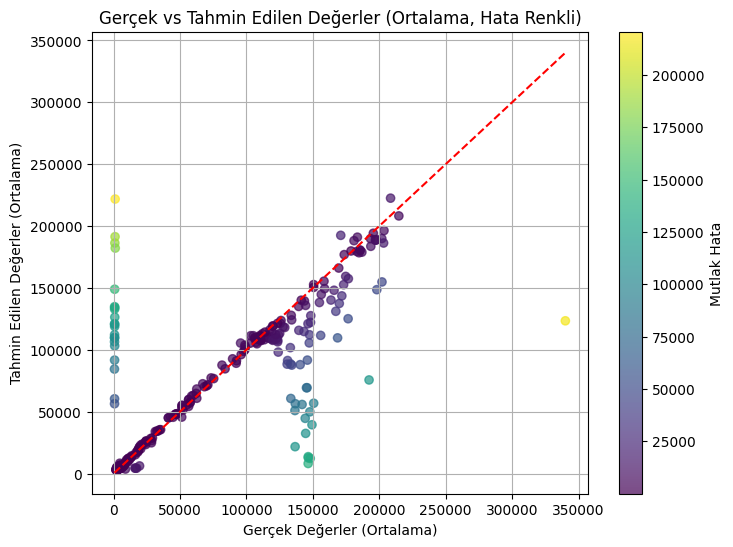

In [ ]:
# Ortalama gerçek ve tahmin değerleri
y_test_mean = y_test.mean(axis=1)
y_pred_mean = y_pred.mean(axis=1)

residuals = y_test_mean - y_pred_mean

plt.figure(figsize=(8,6))
sc = plt.scatter(y_test_mean, y_pred_mean, c=np.abs(residuals), cmap='viridis', alpha=0.7)
plt.colorbar(sc, label='Mutlak Hata')
plt.plot([y_test_mean.min(), y_test_mean.max()], [y_test_mean.min(), y_test_mean.max()], 'r--')
plt.xlabel('Gerçek Değerler (Ortalama)')
plt.ylabel('Tahmin Edilen Değerler (Ortalama)')
plt.title('Gerçek vs Tahmin Edilen Değerler (Ortalama, Hata Renkli)')
plt.grid(True)
plt.show()

#Tahmin hatalarını renk tonlarıyla gösterir ve gerçek vs tahmin edilen değerlerin ortalamasını karşılaştırır.